# Seq2Vec Sentiment Modeling in Tensorflow

## 1.0 - Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import mean_absolute_error
from keras import backend as K
from keras.layers import Dropout
import os
import numpy as np
import seaborn as sns
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
EVAL_DIR = os.path.join(ROOT_DIR, "evaluation")
MODEL_PERF_DIR = os.path.join(EVAL_DIR, "model_performance")
GRAPHS_DIR = os.path.join(EVAL_DIR, "graphs")
writepath = os.path.join(MODEL_PERF_DIR, "performance.csv")

## 1.1 Import Data 

In [3]:
validation_df = pd.read_csv(os.path.join(DATA_DIR,'raw','validation.csv'))
training_df = pd.read_csv(os.path.join(DATA_DIR,'raw','training.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR,'raw','test.csv'))

X_train = training_df['review']
y_train = training_df['star']

X_val = validation_df['review']
y_val = validation_df['star']

X_test = test_df['review']
y_test = test_df['star']

# Convert to tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=1024).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(buffer_size=1024).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(buffer_size=1024).batch(128)

2022-03-16 05:59:38.437190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 05:59:38.437409: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 05:59:38.437482: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42b10f96906e): /proc/driver/nvidia/version does not exist
2022-03-16 05:59:38.438670: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.0 Create embedding layer & Build simple model

In [4]:
handle = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'

emb_layer = hub.KerasLayer(handle = handle, output_shape=(20,1),
               input_shape=(None,),dtype=tf.string,trainable=True, name='embed')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

2022-03-16 05:59:38.745032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
embed = hub.load(handle)
embeddings = embed(["man","woman"])
embeddings

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 3.9687425e-01, -6.3695002e-01, -6.7363518e-01, -1.3100165e-01,
         5.2906036e-01,  2.3391739e-01, -1.7667708e-01,  1.0469885e+00,
         1.5244880e+00,  8.3604610e-01, -7.9439002e-01,  1.0453002e-01,
        -2.2940248e-02, -1.4738902e-01, -8.3987337e-01,  1.0697368e+00,
        -4.5744944e-01, -4.4647139e-01, -1.3669002e+00,  1.6243970e-01],
       [ 4.5780963e-01, -6.5106559e-01, -4.7487444e-01, -1.3545550e-01,
         7.5560737e-01,  1.3068053e-01, -2.7652311e-01,  1.2009813e+00,
         1.6298714e+00,  1.1437336e+00, -6.3142008e-01,  6.7427382e-04,
        -3.1341049e-01, -2.5012997e-01, -8.7322730e-01,  7.1451533e-01,
        -4.2308569e-01, -7.8139108e-01, -1.1334857e+00,  1.6536513e-01]],
      dtype=float32)>

## Baseline

In [6]:
epochs = 100

base_model = keras.Sequential([
        layers.Input(shape=(), name="Input", dtype=tf.string),
        emb_layer,
        layers.Dense(10,activation='relu', dtype=tf.float32),
        layers.Dropout(0.2),
        layers.Dense(1,activation=relu_advanced)],name='2.1-Base-Reg-Swivel')

base_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=keras.optimizers.Adam(lr=0.0003,decay=1e-6),
                   metrics=['mse','mae'])


base_history = base_model.fit(train_ds,
                    epochs = epochs,
                    validation_data=val_ds,
                    callbacks=[callback],
                    verbose=1)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
1351/1351 [==============================] - 20s 14ms/step - loss: 5.8622 - mse: 5.8622 - mae: 1.8542 - val_loss: 2.7318 - val_mse: 2.7318 - val_mae: 1.0737
Epoch 2/100
1351/1351 [==============================] - 23s 17ms/step - loss: 2.4942 - mse: 2.4942 - mae: 1.0200 - val_loss: 1.8987 - val_mse: 1.8987 - val_mae: 0.8449
Epoch 3/100
1351/1351 [==============================] - 23s 17ms/step - loss: 1.9954 - mse: 1.9954 - mae: 0.8803 - val_loss: 1.6619 - val_mse: 1.6619 - val_mae: 0.7787
Epoch 4/100
1351/1351 [==============================] - 23s 17ms/step - loss: 1.7761 - mse: 1.7761 - mae: 0.8217 - val_loss: 1.5372 - val_mse: 1.5372 - val_mae: 0.7486
Epoch 5/100
1351/1351 [==============================] - 23s 17ms/step - loss: 1.6391 - mse: 1.6391 - mae: 0.7866 - val_loss: 1.4688 - val_mse: 1.4688 - val_mae: 0.7296
Epoch 6/100
1351/1351 [==============================] - 23s 17ms/step - loss: 1.5331 - mse: 1.5331 - mae: 0.7609 - val_loss: 1.4191 - val_mse: 1.4191 - va

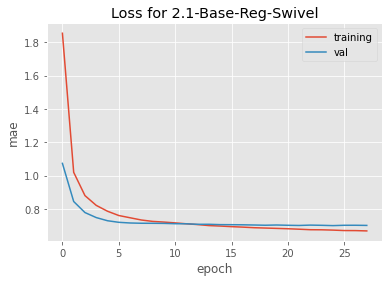

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.1-Base-Reg-Swivel.png


In [7]:
plot_loss(base_history,base_model)

The prediction values range between [1.] and [5.]
Mean Absolute Error: 0.6955374655025776


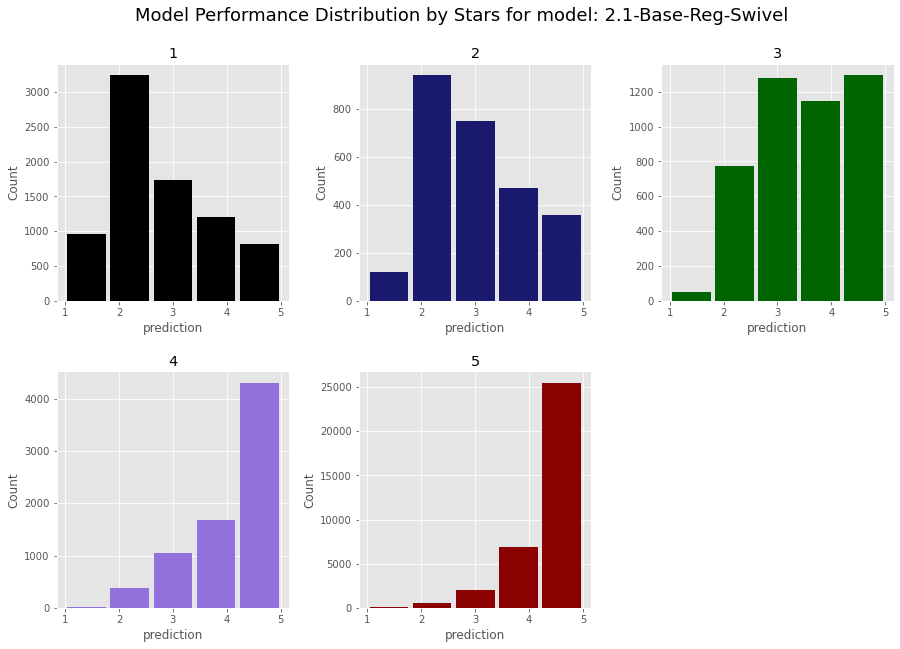

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


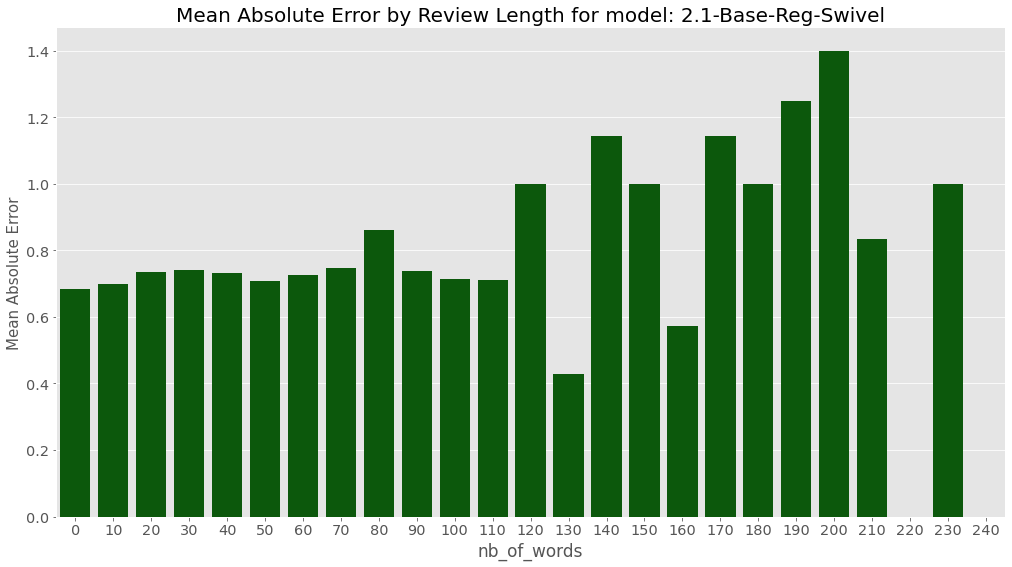

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.81      0.12      0.21      7964
           2       0.16      0.36      0.22      2640
           3       0.19      0.28      0.22      4548
           4       0.15      0.23      0.18      7414
           5       0.79      0.73      0.76     35047

    accuracy                           0.53     57613
   macro avg       0.42      0.34      0.32     57613
weighted avg       0.63      0.53      0.54     57613

"I like the top but it took long to deliver" receives a score of [3.0728972]
"This app is trash" receives a score of [1.522956]
"The app is extremely slow, but I still like it" receives a score of [2.8716094]
"I Do not Love this App" receives a score of [5.]
"Too many glitches" receives a score of [2.1420038]
"Worthless app" receives a score of [4.179397]
"Do not download this app" receives a score of [1.9798446]
"Horrible" receives a score of [3.8596985]
"Could be better

In [8]:
performance_evaluation(X_test, y_test, base_model)

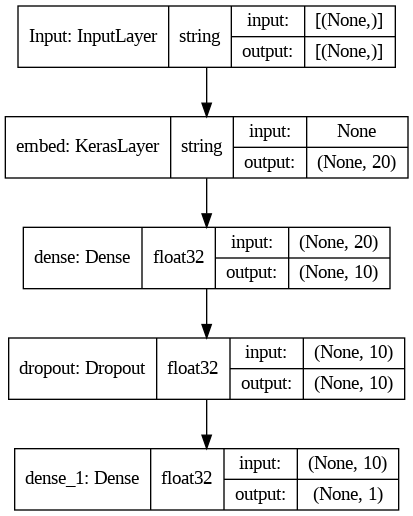

In [9]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{base_model.name}.png')
tf.keras.utils.plot_model(base_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [10]:
base_model.save(os.path.join(MODELS_DIR,base_model.name))

2022-03-16 06:15:55.919597: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-Base-Reg-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-Base-Reg-Swivel/assets


## RNN

In [11]:
embed
embed(X_train).shape

TensorShape([172839, 20])

In [12]:
rnn_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.Bidirectional(layers.SimpleRNN(10, activation='tanh',return_sequences=False)),
    # layers.SimpleRNN(5, activation='tanh',return_sequences=False),
    layers.Dense(5, activation='relu'),
    # layers.Dropout(0.3),
    # layers.Dense(10, activation='relu'),
    # layers.Dropout(0.3),
    # layers.Dense(5, activation='tanh'),
    layers.Dropout(0.05),
    layers.Dense(1,activation=relu_advanced)
],name='2.1-RNN-Reg-Bidirect-Swivel')

rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['mse','mae'])

num_epochs=100
rnn_history=rnn_model.fit(train_ds, 
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 83s 56ms/step - loss: 2.3796 - mse: 2.3796 - mae: 1.0919 - val_loss: 1.3768 - val_mse: 1.3768 - val_mae: 0.7698
Epoch 2/100
1351/1351 [==============================] - 91s 67ms/step - loss: 1.3921 - mse: 1.3921 - mae: 0.7727 - val_loss: 1.3008 - val_mse: 1.3008 - val_mae: 0.7280
Epoch 3/100
1351/1351 [==============================] - 82s 61ms/step - loss: 1.3104 - mse: 1.3104 - mae: 0.7329 - val_loss: 1.2806 - val_mse: 1.2806 - val_mae: 0.7116
Epoch 4/100
1351/1351 [==============================] - 91s 68ms/step - loss: 1.2694 - mse: 1.2694 - mae: 0.7133 - val_loss: 1.2705 - val_mse: 1.2705 - val_mae: 0.7093
Epoch 5/100
1351/1351 [==============================] - 102s 75ms/step - loss: 1.2407 - mse: 1.2407 - mae: 0.6996 - val_loss: 1.2658 - val_mse: 1.2658 - val_mae: 0.7024
Epoch 6/100
1351/1351 [==============================] - 87s 65ms/step - loss: 1.2139 - mse: 1.2139 - mae: 0.6870 - val_loss: 1.2646 - val_mse: 1.2646 - v

In [13]:
rnn_model.summary()

Model: "2.1-RNN-Reg-Bidirect-Swivel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (KerasLayer)           (None, 20)                389380    
_________________________________________________________________
reshape (Reshape)            (None, 20, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 389,731
Trainable params: 389,731
Non-trainable params: 0
_________________________________

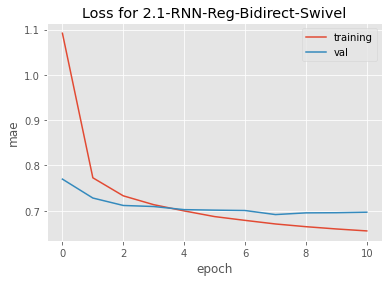

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.1-RNN-Reg-Bidirect-Swivel.png


In [14]:
plot_loss(rnn_history,rnn_model)

The prediction values range between [1.] and [5.]
Mean Absolute Error: 0.6909378091750126


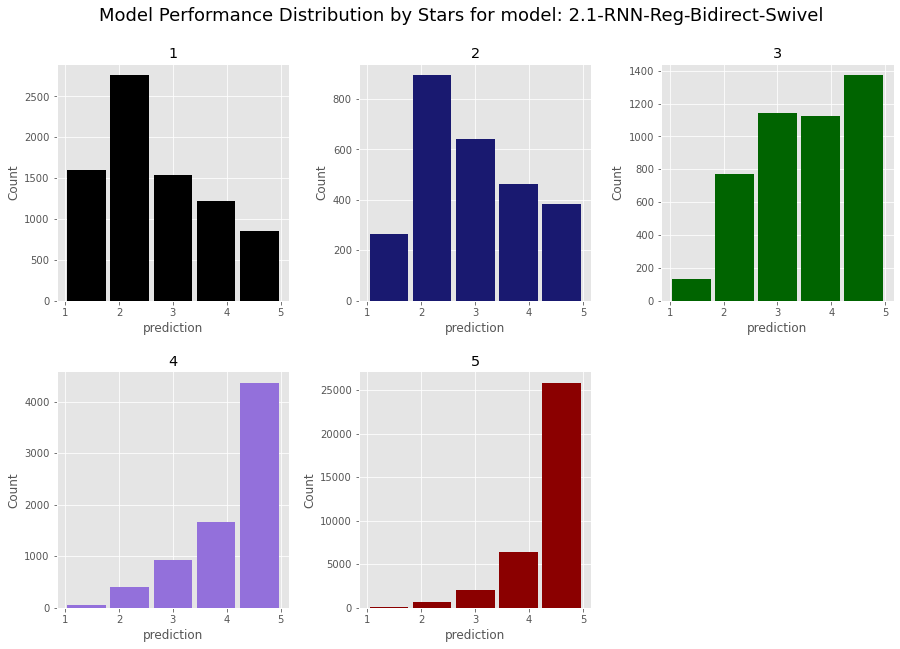

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


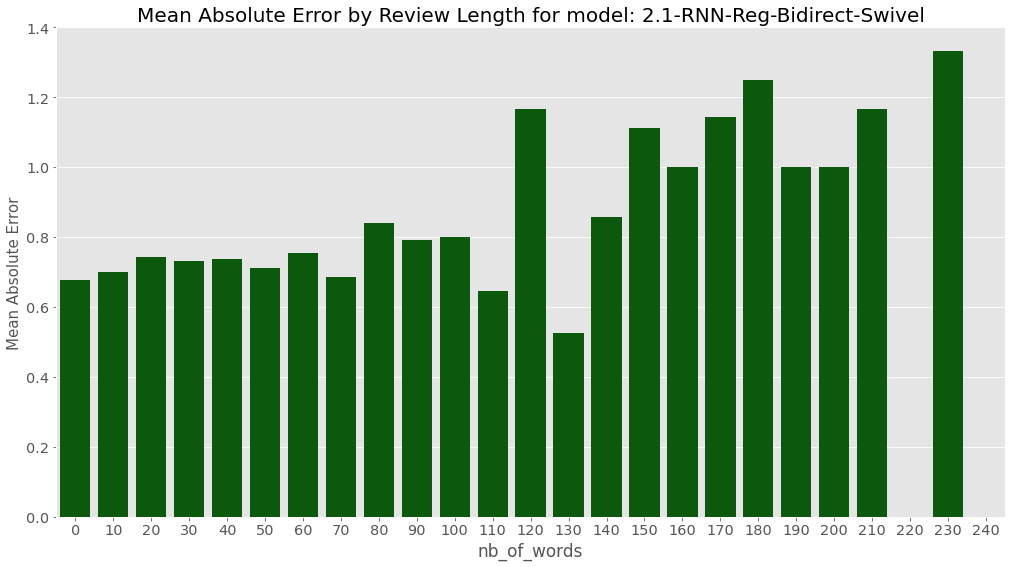

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.75      0.20      0.32      7964
           2       0.16      0.34      0.22      2640
           3       0.18      0.25      0.21      4548
           4       0.15      0.22      0.18      7414
           5       0.79      0.74      0.76     35047

    accuracy                           0.54     57613
   macro avg       0.41      0.35      0.34     57613
weighted avg       0.62      0.54      0.56     57613

"I like the top but it took long to deliver" receives a score of [2.9872055]
"This app is trash" receives a score of [1.4233139]
"The app is extremely slow, but I still like it" receives a score of [2.5653]
"I Do not Love this App" receives a score of [5.]
"Too many glitches" receives a score of [2.513032]
"Worthless app" receives a score of [4.482747]
"Do not download this app" receives a score of [2.1282568]
"Horrible" receives a score of [3.978911]
"Could be better but

In [15]:
performance_evaluation(X_test, y_test, rnn_model)

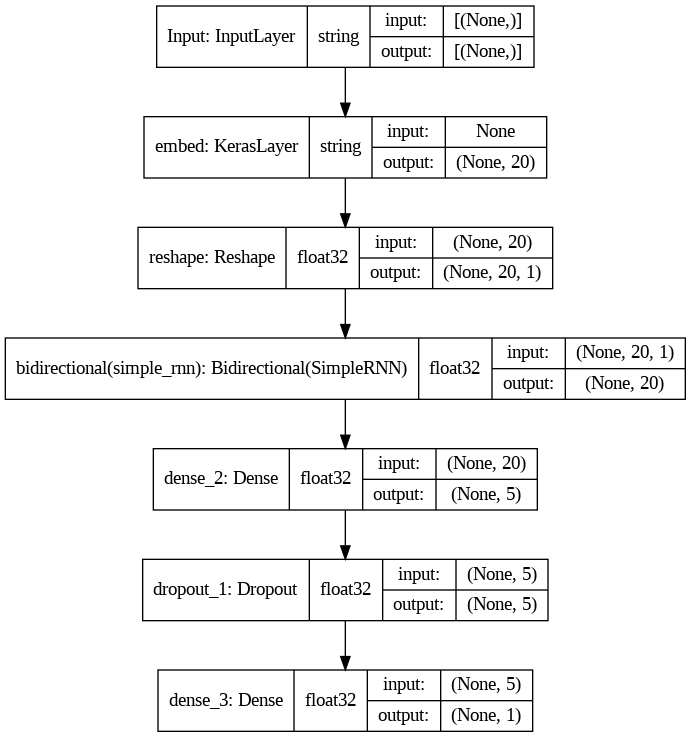

In [16]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{rnn_model.name}.png')
tf.keras.utils.plot_model(rnn_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [17]:
rnn_model.save(os.path.join(MODELS_DIR,rnn_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-RNN-Reg-Bidirect-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-RNN-Reg-Bidirect-Swivel/assets


In [18]:
# max(y_pred)

In [19]:
gru_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.Bidirectional(layers.GRU(10, activation='tanh',return_sequences=True)),
    layers.GRU(4, activation='tanh',return_sequences=False),
    layers.Dropout(0.2),
    # layers.Dense(5,activation='relu'),
    layers.Dense(1,activation=relu_advanced)
],name='2.1-GRU-Reg-Bidirect-Swivel')
gru_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
gru_history=gru_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 118s 78ms/step - loss: 3.3488 - mse: 3.3488 - mae: 1.4403 - val_loss: 1.3645 - val_mse: 1.3645 - val_mae: 0.7450
Epoch 2/100
1351/1351 [==============================] - 98s 72ms/step - loss: 1.5905 - mse: 1.5905 - mae: 0.8124 - val_loss: 1.3605 - val_mse: 1.3605 - val_mae: 0.6770
Epoch 3/100
1351/1351 [==============================] - 101s 75ms/step - loss: 1.3695 - mse: 1.3695 - mae: 0.7096 - val_loss: 1.3370 - val_mse: 1.3370 - val_mae: 0.6729
Epoch 4/100
1351/1351 [==============================] - 90s 66ms/step - loss: 1.2920 - mse: 1.2920 - mae: 0.6798 - val_loss: 1.3160 - val_mse: 1.3160 - val_mae: 0.6766
Epoch 5/100
1351/1351 [==============================] - 95s 71ms/step - loss: 1.2281 - mse: 1.2281 - mae: 0.6648 - val_loss: 1.3163 - val_mse: 1.3163 - val_mae: 0.6731
Epoch 6/100
1351/1351 [==============================] - 93s 69ms/step - loss: 1.1869 - mse: 1.1869 - mae: 0.6561 - val_loss: 1.2988 - val_mse: 1.2988 - 

In [20]:
gru_model.save(os.path.join(MODELS_DIR,gru_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-GRU-Reg-Bidirect-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-GRU-Reg-Bidirect-Swivel/assets


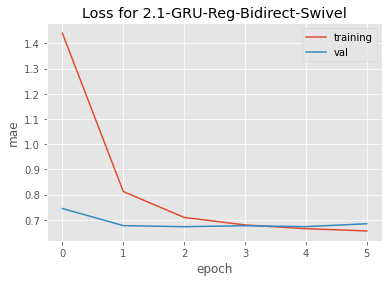

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.1-GRU-Reg-Bidirect-Swivel.png


In [21]:
plot_loss(gru_history,gru_model)

The prediction values range between [1.] and [5.]
Mean Absolute Error: 0.6779719854893861


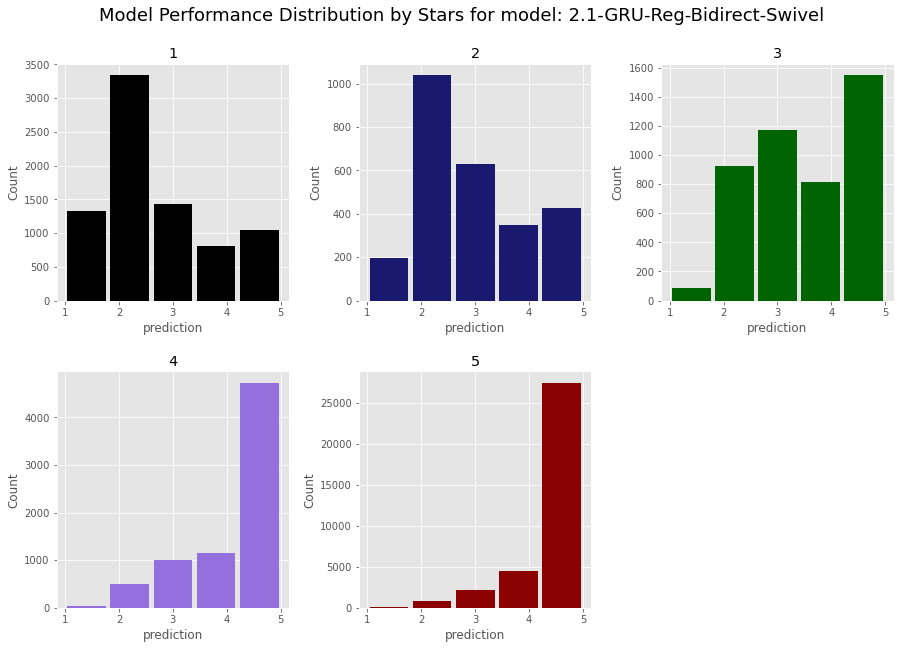

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


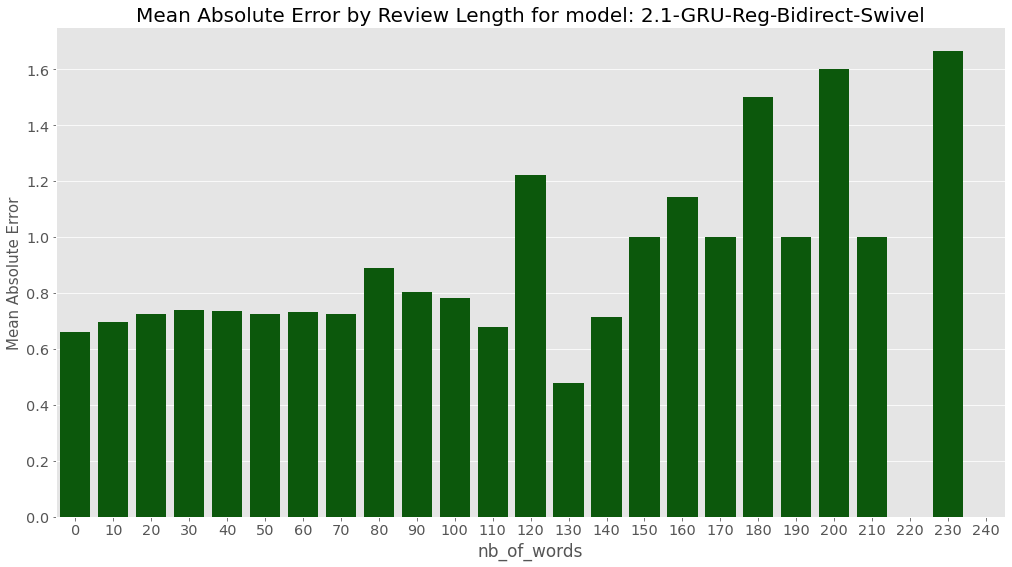

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.78      0.17      0.28      7964
           2       0.16      0.39      0.22      2640
           3       0.18      0.26      0.21      4548
           4       0.15      0.16      0.15      7414
           5       0.78      0.78      0.78     35047

    accuracy                           0.56     57613
   macro avg       0.41      0.35      0.33     57613
weighted avg       0.62      0.56      0.56     57613

"I like the top but it took long to deliver" receives a score of [2.6326323]
"This app is trash" receives a score of [1.4184693]
"The app is extremely slow, but I still like it" receives a score of [2.4162242]
"I Do not Love this App" receives a score of [5.]
"Too many glitches" receives a score of [1.7929196]
"Worthless app" receives a score of [4.5146847]
"Do not download this app" receives a score of [1.7794781]
"Horrible" receives a score of [3.895031]
"Could be bette

In [22]:
performance_evaluation(X_test, y_test, gru_model)

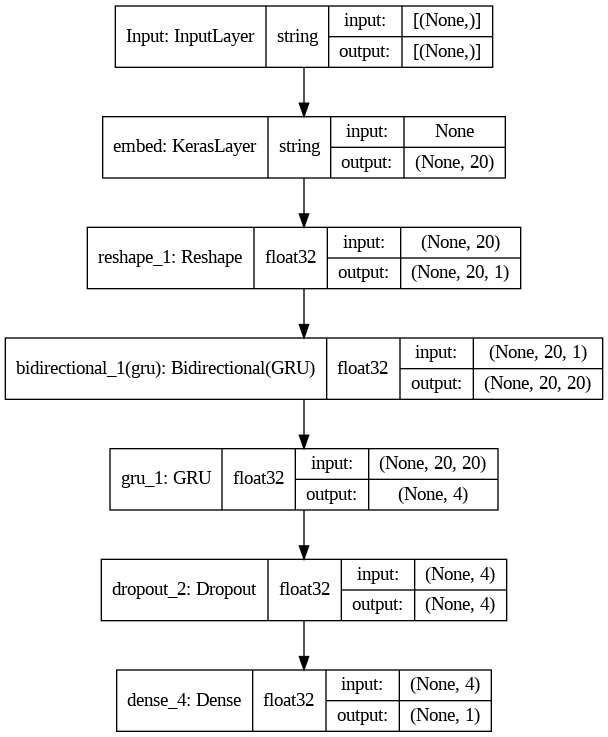

In [23]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{gru_model.name}.png')
tf.keras.utils.plot_model(gru_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

## LSTM

In [24]:
lstm_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.Bidirectional(layers.LSTM(10, activation='tanh',return_sequences=True)),
    layers.LSTM(10, activation='tanh',return_sequences=False),
    # layers.Dense(5,activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1,activation=relu_advanced)
],name='2.1-LSTM-Reg-Bidirect-Swivel')
lstm_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
lstm_history=lstm_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 113s 77ms/step - loss: 2.3585 - mse: 2.3585 - mae: 1.0604 - val_loss: 1.3382 - val_mse: 1.3382 - val_mae: 0.6672
Epoch 2/100
1351/1351 [==============================] - 114s 85ms/step - loss: 1.2843 - mse: 1.2843 - mae: 0.6913 - val_loss: 1.3145 - val_mse: 1.3145 - val_mae: 0.6755
Epoch 3/100
1351/1351 [==============================] - 98s 73ms/step - loss: 1.2167 - mse: 1.2167 - mae: 0.6630 - val_loss: 1.3203 - val_mse: 1.3203 - val_mae: 0.6778
Epoch 4/100
1351/1351 [==============================] - 101s 74ms/step - loss: 1.1891 - mse: 1.1891 - mae: 0.6498 - val_loss: 1.3014 - val_mse: 1.3014 - val_mae: 0.6747


The prediction values range between [1.] and [5.]
Mean Absolute Error: 0.6641556593130022


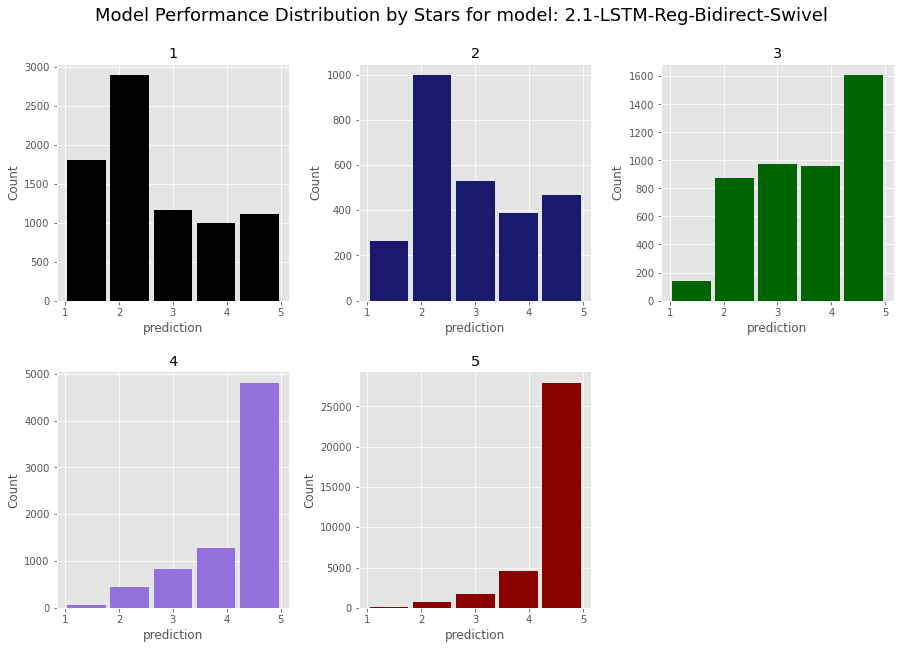

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


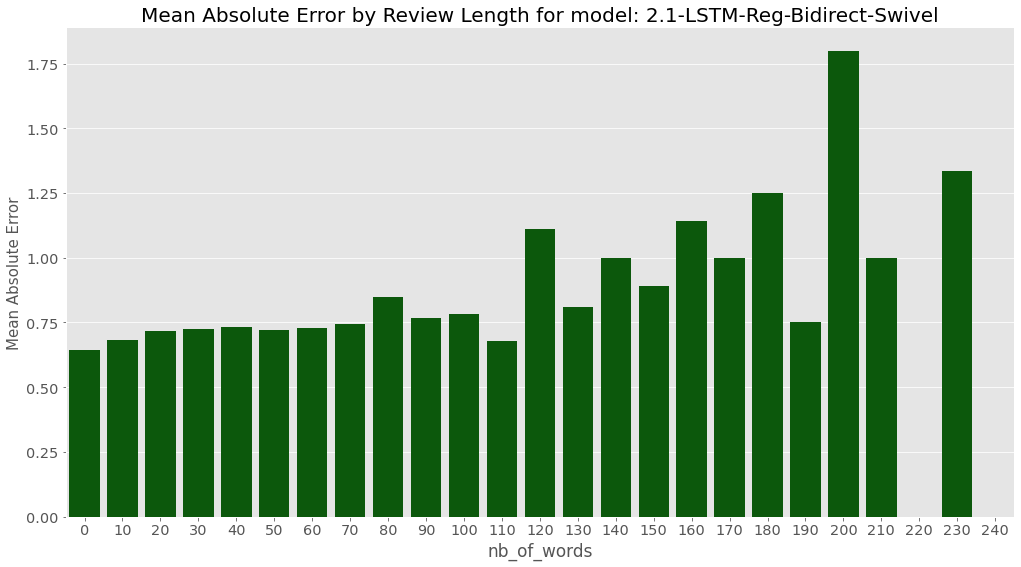

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.76      0.23      0.35      7964
           2       0.17      0.38      0.23      2640
           3       0.19      0.21      0.20      4548
           4       0.16      0.17      0.16      7414
           5       0.78      0.80      0.79     35047

    accuracy                           0.57     57613
   macro avg       0.41      0.36      0.35     57613
weighted avg       0.62      0.57      0.57     57613

"I like the top but it took long to deliver" receives a score of [2.659276]
"This app is trash" receives a score of [1.09178]
"The app is extremely slow, but I still like it" receives a score of [2.3084788]
"I Do not Love this App" receives a score of [5.]
"Too many glitches" receives a score of [1.9125248]
"Worthless app" receives a score of [4.5588317]
"Do not download this app" receives a score of [1.7102097]
"Horrible" receives a score of [4.3726473]
"Could be better 

In [25]:
performance_evaluation(X_test, y_test, lstm_model)

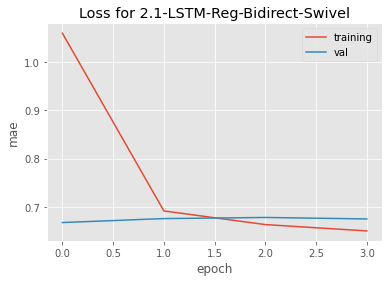

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.1-LSTM-Reg-Bidirect-Swivel.png


In [26]:
plot_loss(lstm_history,lstm_model)

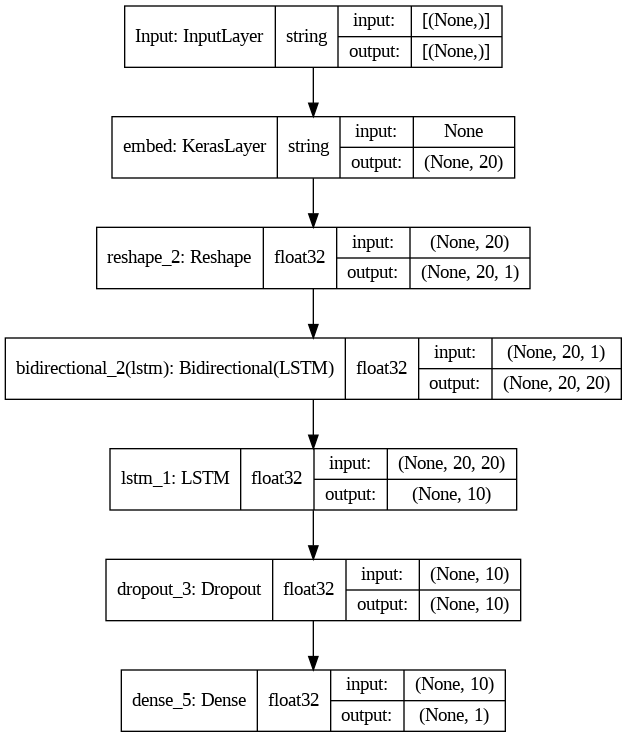

In [27]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{lstm_model.name}.png')
tf.keras.utils.plot_model(lstm_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [28]:
lstm_model.save(os.path.join(MODELS_DIR,lstm_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-LSTM-Reg-Bidirect-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-LSTM-Reg-Bidirect-Swivel/assets
